In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from scipy.optimize import fsolve

In [3]:
import pandas as pd

In [4]:
df_emp_pre = pd.read_csv('../../Data/Downloads/Pre/pre_emp.csv')
df_emp_post = pd.read_csv('../../Data/Downloads/Post/post_emp.csv')

In [5]:
df_cap_pre = pd.read_csv('../../Data/Downloads/Pre/pre_cap.csv')
df_cap_post = pd.read_csv('../../Data/Downloads/Post/post_cap.csv')

In [6]:
df_exp_pre = pd.read_csv('../../Data/Downloads/Pre/pre_exp.csv')
df_exp_post = pd.read_csv('../../Data/Downloads/Post/post_exp.csv')

In [10]:
df_pi_post = pd.read_csv('../../Data/Downloads/Post/post_CPI.csv')

In [7]:
df_cns_post = pd.read_csv('../../Data/Analysis/Post/post_mu_ratio_dynamic.csv')

In [8]:
df_pop_post = pd.read_csv('../../Data/Downloads/Post/post_pop.csv')

In [6]:
df_XA_pre = pd.read_csv('../../Data/Downloads/Pre/pre_exp.csv')
df_XA_post = pd.read_csv('../../Data/Downloads/Post/post_exp.csv')

In [47]:
c_m_1955 = 5630 * 89276 / 1000000

In [48]:
c_m_1955

502.62388

In [13]:
K_1955 = 31139283000 / 27.7

In [14]:
K_1955

1124161841.1552346

In [18]:
class StaticAllocation:
    ###
    # finds allocation of capital and labor across sectors given consumption of manufactured goods
    ###
    
    def __init__(self,
                 α_KA    = 0.15,
                 α_LA    = 0.55,
                 α_KM    = 0.6, 
                 α_LM    = 0.4,
                 X_A     = 1,
                 X_M     = 1,
                 K       = K_1955,
                 L       = 3913000,
                 η_A     = 0.15,
                 η_M     = 0.85,
                 γ_A     = 0.1,
                 τ_R     = 0,
                 τ_W     = 0,
                 C_M     = 502.62388,
                 ):
        
        self.α_KA, self.α_LA = α_KA, α_LA
        self.α_KM, self.α_LM = α_KM, α_LM
        self.X_A,  self.X_M  = X_A , X_M
        self.L,    self.K    = L   , K
        self.η_A,  self.η_M  = η_A , η_M
        self.γ_A             = γ_A
        self.τ_R,  self.τ_W  = τ_R , τ_W
        self.C_M             = C_M
    
    def Y_A(self, κ):
        ###
        # the production function for sector A
        ###
        X_A, α_KA, α_LA = self.X_A, self.α_KA, self.α_LA
        K, L            = self.K, self.L
        
        λ = self.λ(κ)
        
        K_A = (1 - κ) * K 
        L_A = (1 - λ) * L
        
        Y_A = X_A * (K_A ** α_KA) * (L_A ** α_LA)
        return Y_A
    
    
    def Y_M(self, κ):
        ###
        # the production function for sector M
        ###
        X_M, α_KM, α_LM = self.X_M, self.α_KM, self.α_LM
        K, L            = self.K, self.L
        
        λ = self.λ(κ)
        
        K_M = κ * K 
        L_M = λ * L
        
        Y_M = X_M * (K_M ** α_KM) * (L_M ** α_LM)
        return Y_M
    
    
    def λ(self, κ):
        ###
        # finds λ given κ
        ###
        α_KA, α_LA = self.α_KA, self.α_LA
        α_KM, α_LM = self.α_KM, self.α_LM
        η_A , η_M  = self.η_A , self.η_M
        τ_R , τ_W  = self.τ_R , self.τ_W
        
        temp = (α_LA / α_LM) * (α_KM / α_KA) * ((1 + τ_W) / (1 + τ_R)) * ((1 - κ) / κ)
        λ = (1 + temp) ** (-1)
        return λ
    
    
    def solve_κ(self):
        ###
        # equation for κ
        ###
        α_KA      = self.α_KA
        α_KM      = self.α_KM
        η_A, η_M  = self.η_A, self.η_M
        γ_A       = self.γ_A
        τ_R       = self.τ_R
        C_M       = self.C_M
        
        const = (η_M / η_A) * (α_KM / α_KA) * (1 / (1 + τ_R))
        
        func = lambda κ: const * (1 - (γ_A / self.Y_A(κ))) * (self.Y_M(κ) / C_M) * ((1 - κ) / κ) - 1
        
        κ_initial_guess = 0.8
        κ = fsolve(func, κ_initial_guess)[0]
        
        return κ
    
    def solve_λ(self):
        ###
        # finds equilibrium labor allocation
        ###
        
        κ = self.solve_κ()
        λ = self.λ(κ)
        
        return λ
    
    
    def solve_Y_A(self):
        ###
        # finds equilibrium labor allocation
        ###
        
        κ = self.solve_κ()
        Y_A = self.Y_A(κ)
        
        return Y_A
    
    
    def solve_Y_M(self):
        ###
        # finds equilibrium labor allocation
        ###
        
        κ = self.solve_κ()
        Y_M = self.Y_M(κ)
        
        return Y_M

In [19]:
alloc = StaticAllocation()

In [20]:
alloc.solve_κ()

/Users/satoshi/miniconda3/envs/quantecon/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in power


0.8

In [21]:
alloc.solve_Y_M()

/Users/satoshi/miniconda3/envs/quantecon/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in power


72291925.00891717

In [22]:
class PlanningProblem(StaticAllocation):

    def __init__(self, σ=2, β=0.95, δ=0.02):
        
        super().__init__()

        self.σ, self.β = σ, β
        self.δ         = δ

    def u(self, c):
        '''
        Utility function
        ASIDE: If you have a utility function that is hard to solve by hand
        you can use automatic or symbolic differentiation
        See https://github.com/HIPS/autograd
        '''
        σ = self.σ

        return c ** (1 - σ) / (1 - σ) if σ != 1 else np.log(c)

    def u_prime(self, c):
        'Derivative of utility'
        σ = self.σ

        return c ** (-σ)

    def u_prime_inv(self, c):
        'Inverse of derivative of utility'
        σ = self.σ

        return c ** (-1 / σ)

    def f(self, k):
        'Production function of M sector'
        α_KM, X_M = self.α_KM, self.X_M

        return X_M * k ** α_KM

    def f_prime(self, k):
        'Derivative of production function of M sector'
        α_KM, X_M = self.α_KM, self.X_M

        return α_KM * X_M * k ** (α_KM - 1)

    def f_prime_inv(self, k):
        'Inverse of derivative of production function'
        α_KM, X_M = self.α_KM, self.X_M

        return (k / (X_M * α_KM)) ** (1 / (α_KM - 1))

    def next_k_c(self, k, c):
        ''''
        Given the current capital Kt and an arbitrary feasible
        consumption choice Ct, computes Kt+1 by state transition law
        and optimal Ct+1 by Euler equation.
        '''
        β, δ = self.β, self.δ
        u_prime, u_prime_inv = self.u_prime, self.u_prime_inv
        f, f_prime = self.f, self.f_prime

        k_next = f(k) + (1 - δ) * k - c
        c_next = u_prime_inv(u_prime(c) / (β * (f_prime(k_next) + (1 - δ))))

        return k_next, c_next

In [23]:
pp = PlanningProblem()

In [24]:
pp.solve_κ()

/Users/satoshi/miniconda3/envs/quantecon/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in power


0.8

In [25]:
pp.solve_Y_M()

/Users/satoshi/miniconda3/envs/quantecon/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in power


8405.772869424622

In [26]:
def shooting(pp, c0, k0, T=10):
    '''
    Given the initial condition of capital k0 and an initial guess
    of consumption c0, computes the whole paths of c and k
    using the state transition law and Euler equation for T periods.
    '''
    if c0 > pp.f(k0):
        print("initial consumption is not feasible")

        return None

    # initialize vectors of c and k
    c_vec = np.empty(T+1)
    k_vec = np.empty(T+2)

    c_vec[0] = c0
    k_vec[0] = k0

    for t in range(T):
        k_vec[t+1], c_vec[t+1] = pp.next_k_c(k_vec[t], c_vec[t])

    k_vec[T+1] = pp.f(k_vec[T]) + (1 - pp.δ) * k_vec[T] - c_vec[T]

    return c_vec, k_vec

In [27]:
paths = shooting(pp, 0.3, 0.5, T=10)

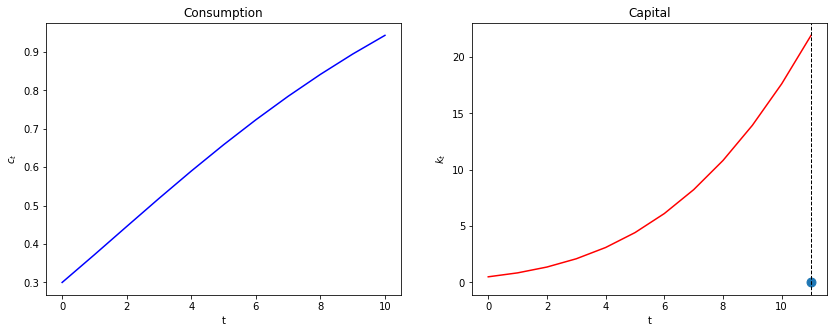

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

colors = ['blue', 'red']
titles = ['Consumption', 'Capital']
ylabels = ['$c_t$', '$k_t$']

T = paths[0].size - 1
for i in range(2):
    axs[i].plot(paths[i], c=colors[i])
    axs[i].set(xlabel='t', ylabel=ylabels[i], title=titles[i])

axs[1].scatter(T+1, 0, s=80)
axs[1].axvline(T+1, color='k', ls='--', lw=1)

plt.show()